In [2]:
from pyzbar import pyzbar
import cv2
import numpy as np
import imutils
from matplotlib import pyplot as plt

In [3]:
def detect(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # compute the Scharr gradient magnitude representation of the images
    # in both the x and y direction using OpenCV 2.4
    ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
    gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)

    # subtract the y-gradient from the x-gradient
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    # blur and threshold the image
    blurred = cv2.blur(gradient, (9, 9))
    (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)

    # construct a closing kernel and apply it to the thresholded image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # perform a series of erosions and dilations
    closed = cv2.erode(closed, None, iterations=4)
    closed = cv2.dilate(closed, None, iterations=4)

    # find the contours in the thresholded image
    cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # if no contours were found, return None
    if len(cnts) == 0:
        return None

    # otherwise, sort the contours by area and compute the rotated
    # bounding box of the largest contour
    c = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
    rect = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)

    # return the bounding box of the barcode
    return box

In [4]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

[[114 610]
 [113 534]
 [442 529]
 [443 606]]


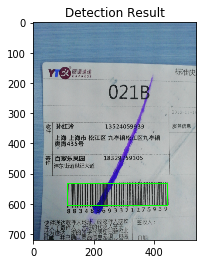

True

In [16]:
image_path = "data/0466eabbc7ba29627426dff8957e2310.jpg"
image = cv2.imread(image_path)
hard_limit_high = 720
hard_limit_width = 960
#resize image
#'''
if image.shape[0] > hard_limit_width:
    image = image_resize(image, width=hard_limit_width)
if image.shape[1] > hard_limit_high:
    image = image_resize(image, height=hard_limit_high)
#'''
# find the barcodes in the image and decode each of the barcodes
barcodes = pyzbar.decode(image)

# loop over the detected barcodes
for barcode in barcodes:
    # extract the bounding box location of the barcode and draw the
    # bounding box surrounding the barcode on the image
    (x, y, w, h) = barcode.rect
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # the barcode data is a bytes object so if we want to draw it on
    # our output image we need to convert it to a string first
    barcodeData = barcode.data.decode("utf-8")
    barcodeType = barcode.type

    # draw the barcode data and barcode type on the image
    text = "{} ({})".format(barcodeData, barcodeType)
    cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    print(barcode.rect)
    print(text)

box = detect(image)
print(box)
cv2.rectangle(image, tuple(box[1]), tuple(box[3]), (0, 255, 0), 2)
# show the output image
#plt.rcParams["figure.figsize"] = (image.shape[0],image.shape[1])
plt.imshow(image)
plt.title('Detection Result')
plt.show()
cv2.imwrite("data/output.png", image)